Train Columns: Index(['Time', 'year', 'month', 'day', 'Sl_cor', 'so_m3', 'thetao_m3', 'M_eta',
       'M_xi', 'V_eta', 'V_xi', 'tp'],
      dtype='object')
Test Columns: Index(['Time', 'year', 'month', 'day', 'Sl_cor', 'so_m3', 'thetao_m3', 'M_eta',
       'M_xi', 'V_eta', 'V_xi', 'tp'],
      dtype='object')


<ipython-input-19-42a07e100f48>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'date'] = pd.to_datetime(df[['year', 'month', 'day']])
<ipython-input-19-42a07e100f48>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'date'] = pd.to_datetime(df[['year', 'month', 'day']])
<ipython-input-19-42a07e100f48>:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to 

Epoch 1, Loss: 0.7269
Epoch 2, Loss: 0.4252
Epoch 3, Loss: 0.3276
Epoch 4, Loss: 0.2813
Epoch 5, Loss: 0.2475
Epoch 6, Loss: 0.2330
Epoch 7, Loss: 0.2131
Epoch 8, Loss: 0.1977
Epoch 9, Loss: 0.1950
Epoch 10, Loss: 0.1807
Epoch 11, Loss: 0.1702
Epoch 12, Loss: 0.1608
Epoch 13, Loss: 0.1509
Epoch 14, Loss: 0.1432
Epoch 15, Loss: 0.1342
Epoch 16, Loss: 0.1302
Epoch 17, Loss: 0.1245
Epoch 18, Loss: 0.1177
Epoch 19, Loss: 0.1146
Epoch 20, Loss: 0.1110
Evaluating Multivariate Forecasting...
MSE: 0.6230, MAE: 0.5542


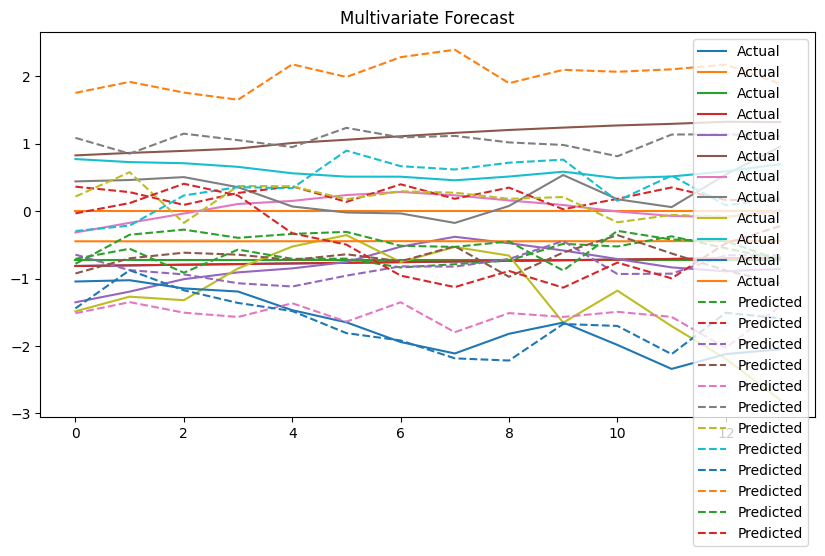

Evaluating Univariate Forecasting...
MSE: 1.3382, MAE: 0.7346


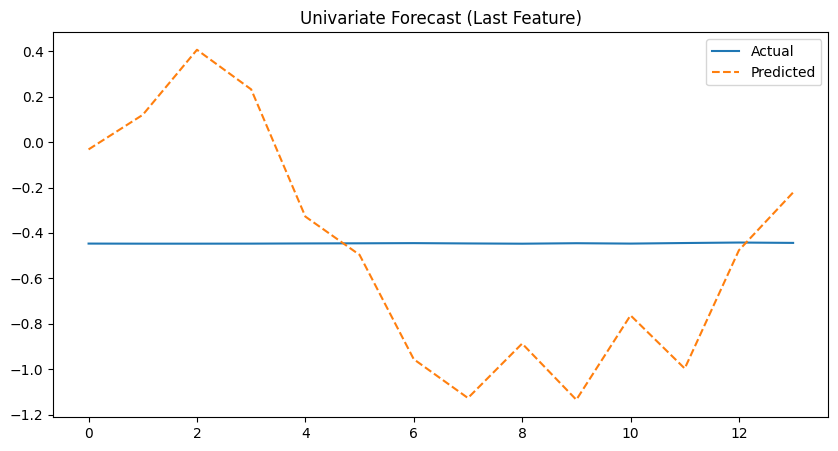

In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Initialize Weights & Biases
wandb.init(project="ts-forecasting-ddpm")

# Load datasets
def load_data(train_path, test_path):
    train_df = pd.read_excel(train_path)
    test_df = pd.read_excel(test_path)

    print("Train Columns:", train_df.columns)
    print("Test Columns:", test_df.columns)

    for df in [train_df, test_df]:
        # Ensure year, month, day are numeric
        for col in ['year', 'month', 'day']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Drop rows with NaN values in date-related columns
        df.dropna(subset=['year', 'month', 'day'], inplace=True)

        # Ensure valid month and day ranges
        df = df[(df['month'].between(1, 12)) & (df['day'].between(1, 31))]

        # Convert to datetime
        df.loc[:, 'date'] = pd.to_datetime(df[['year', 'month', 'day']])

    # Ensure 'date' column exists before setting index
    if 'date' in train_df.columns:
        train_df = train_df.set_index('date').drop(columns=['year', 'month', 'day', 'Time'])
    if 'date' in test_df.columns:
        test_df = test_df.set_index('date').drop(columns=['year', 'month', 'day', 'Time'])

    return train_df, test_df

# Preprocess dataset
def prepare_data(df, seq_len=96, pred_len=14):
    # Ensure all columns are numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna() #remove any NaN that result from the conversion.
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    X, y = [], []
    for i in range(len(df_scaled) - seq_len - pred_len):
        X.append(df_scaled[i:i+seq_len])
        y.append(df_scaled[i+seq_len:i+seq_len+pred_len])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), scaler

# Define Conditional DDPM Model
class DDPM(nn.Module):
    def __init__(self, input_dim, seq_len, pred_len):
        super(DDPM, self).__init__()
        self.diffusion_steps = 100  # Example, can be tuned
        self.model = nn.Sequential(
            nn.Linear(seq_len * input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, pred_len * input_dim)
        )
        self.input_dim = input_dim
        self.pred_len = pred_len

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.model(x)
        x = x.view(x.size(0), self.pred_len, self.input_dim) #reshape to pred_len and input_dim
        return x

# Train function
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        wandb.log({"Epoch": epoch+1, "Loss": avg_loss})
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Evaluation function
def evaluate_model(model, X_test, y_test, scaler, univariate=False):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
        y_test = y_test.numpy()

    if univariate:
        y_pred, y_test = y_pred[:, :, -1], y_test[:, :, -1]

    mse, mae = np.mean((y_pred - y_test) ** 2), np.mean(np.abs(y_pred - y_test))
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")
    wandb.log({"MSE": mse, "MAE": mae})
    return y_pred, y_test

# Visualization
def plot_results(y_pred, y_test, title="Forecast vs Actual"):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test[0], label="Actual")
    plt.plot(y_pred[0], label="Predicted", linestyle='dashed')
    plt.legend()
    plt.title(title)
    plt.show()

# Main execution
if __name__ == "__main__":
    train_df, test_df = load_data("timeseries_train.xlsx", "timeseries_test.xlsx")
    X_train, y_train, scaler = prepare_data(train_df, 96, 14)
    X_test, y_test, _ = prepare_data(test_df, 96, 14)
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

    model = DDPM(input_dim=X_train.shape[2], seq_len=96, pred_len=14)
    criterion, optimizer = nn.MSELoss(), optim.Adam(model.parameters(), lr=0.001)
    wandb.watch(model)
    train_model(model, train_loader, criterion, optimizer, epochs=20)

    print("Evaluating Multivariate Forecasting...")
    y_pred_multi, y_test_multi = evaluate_model(model, X_test, y_test, scaler)
    plot_results(y_pred_multi, y_test_multi, "Multivariate Forecast")

    print("Evaluating Univariate Forecasting...")
    y_pred_uni, y_test_uni = evaluate_model(model, X_test, y_test, scaler, univariate=True)
    plot_results(y_pred_uni, y_test_uni, "Univariate Forecast (Last Feature)")

    with open("wandb_dashboard.txt", "w") as f:
        f.write(f"W&B Dashboard: {wandb.run.get_url()}\n")

In [16]:
# # Load datasets
def load_data(train_path, test_path):
    train_df = pd.read_excel(train_path)
    test_df = pd.read_excel(test_path)

    print("Train Columns:", train_df.columns)
    print("Test Columns:", test_df.columns)

    for df in [train_df, test_df]:
        # Ensure year, month, day are numeric
        for col in ['year', 'month', 'day']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Drop rows with NaN values in date-related columns
        df.dropna(subset=['year', 'month', 'day'], inplace=True)

        # Ensure valid month and day ranges
        df = df[(df['month'].between(1, 12)) & (df['day'].between(1, 31))]

        # Convert to datetime
        df = df.assign(date=pd.to_datetime(df[['year', 'month', 'day']], errors='coerce'))

        # Ensure 'date' column exists before setting index
        if 'date' in df.columns:
            df.set_index('date', inplace=True)
            df.drop(columns=['year', 'month', 'day', 'Time'], inplace=True, errors='ignore')

    return train_df, test_df

# Preprocess dataset
def prepare_data(df, seq_len=96, pred_len=14):
    scaler = StandardScaler()

    # Drop non-numeric columns before scaling
    df_numeric = df.select_dtypes(include=[np.number])

    df_scaled = scaler.fit_transform(df_numeric)

    X, y = [], []
    for i in range(len(df_scaled) - seq_len - pred_len):
        X.append(df_scaled[i:i+seq_len])
